# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from collections import OrderedDict

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
df_azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
df_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
df_azdias.shape

(891221, 85)

We can see here how all 85 features have been accounted for along with the first 5 rows. 

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Checking df_azdias
df_azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


We can see here that using the "describe" functionality of Padnas that we'd be able to see the numerical details of 81 columns. However, this means that 4 columns are non-numeric and will need to be dealt with accordingly. Furthermore, it seems that we have a total of 891221 rows instead of 891211 as stated above. I'll just assume that the value in the description is a typo that should be corrected in the future.

Using this, we can also see that we have a number of columns with Null (NaN) values that we will also need to deal with during the cleaning process.

In [6]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Data that is naturally missing per column
azdias_nan = df_azdias.isnull().sum()

azdias_nan[azdias_nan > 0]

CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ 

We already knew that we had columns with quite a number of NaN values but this is just another way of looking at it.

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
for index, row in feat_info.iterrows(): # I'm so sorry for using a for-loop
    missing = row["missing_or_unknown"]
    if 'XX' in missing:
        missing = missing.replace("XX", "'XX'")
    if ',X' in missing: 
        missing = missing.replace("X", "'X'")

    missing = ast.literal_eval(missing)
    column = row["attribute"]
    
    for i in missing: # Yes, I'm doing it again. Sue me.
        df_azdias[column].replace(i, np.NaN, inplace=True)
    # It actually runs pretty quickly, all things considered

# Note to reviewer: If you have any tips on how to make this work without for-loops then let me know

In [9]:
# Data that is naturally missing per column
azdias_nan2 = df_azdias.isnull().sum()

(azdias_nan - azdias_nan2).sum()

-3477091

Good! It seems that there were a lot of missing values that have shown up after making this change. (Not usually a good thing, just happy that my solution worked.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

df_azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

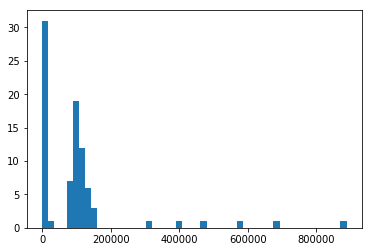

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

column_names = df_azdias.columns
column_isnull = df_azdias.isnull().sum().tolist()

plt.hist(column_isnull, bins=50);

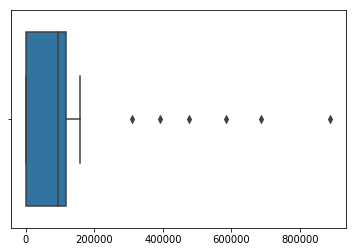

In [12]:
sns.boxplot(column_isnull);

We can see that most columns have null values between 0 and 200,000. However, we have a couple of outliers that have columns greater than 200,000. These are columns that will likely be dropped as instructed in a later task.

In [13]:
cols_to_drop = df_azdias.columns[df_azdias.isnull().sum() > 200000].tolist()

cols_to_drop

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [14]:
df_azdias[cols_to_drop]

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1996.0,NaN,NaN,NaN,5.0
2,NaN,1979.0,NaN,17.0,NaN,NaN
3,2.0,1957.0,NaN,13.0,NaN,1.0
4,NaN,1963.0,NaN,20.0,1.0,NaN
5,3.0,1943.0,NaN,10.0,3.0,NaN
6,NaN,NaN,NaN,NaN,NaN,1.0
7,NaN,1964.0,NaN,14.0,NaN,NaN
8,NaN,1974.0,NaN,16.0,NaN,NaN
9,NaN,1975.0,NaN,17.0,6.0,NaN


Having a look at the columns that need to be dropped specificially for a pattern, we notice that `TITEL_KZ` is practically a column on null values.

There are also many rows that look as if there is no data in them. However some columns such as `FINANZ` and `SEMIO` contain no nulls, so they all contain at least a little bit of data.

In [15]:
df_azdias.drop(cols_to_drop, axis=1, inplace=True)

In [16]:
df_null_search = pd.DataFrame({"cols": df_azdias.columns.tolist(),
                               "null_values": df_azdias.isnull().sum().tolist()})

In [17]:
# Find columns with the same number of null values
df_null_search.sort_values(by="null_values", ascending=False)

,cols,null_values
64,KKK,158064
67,REGIOTYP,158064
43,W_KEIT_KIND_HH,147988
58,KBA05_ANTG4,133324
55,KBA05_ANTG1,133324
65,MOBI_REGIO,133324
59,KBA05_GBZ,133324
56,KBA05_ANTG2,133324
57,KBA05_ANTG3,133324
75,PLZ8_GBZ,116515


In [18]:
df_null_search.groupby("null_values")["cols"].nunique()

null_values
0         24
2881       1
4854       6
18348      1
73499      4
73969      1
77792      2
93148      4
93155      1
93740      3
94572      1
97008      1
97274      1
97375      2
97632      1
99352      3
99611      1
105800     1
108164     1
108315     1
111196     3
116515     7
133324     6
147988     1
158064     2
Name: cols, dtype: int64

We can see that the coluns that have the higher number of same number of nulls are `4854`, `116515`, `133324`. So, let's have a look for what patterns we can find!

In [19]:
df_azdias[df_null_search[df_null_search["null_values"] == 4854].cols.tolist()]

,CJT_GESAMTTYP,GFK_URLAUBERTYP,LP_STATUS_FEIN,LP_STATUS_GROB,RETOURTYP_BK_S,ONLINE_AFFINITAET
0,2.0,10.0,1.0,1.0,5.0,1.0
1,5.0,10.0,2.0,1.0,1.0,3.0
2,3.0,10.0,3.0,2.0,3.0,2.0
3,2.0,1.0,9.0,4.0,2.0,1.0
4,5.0,5.0,3.0,2.0,5.0,5.0
5,2.0,1.0,4.0,2.0,3.0,1.0
6,5.0,12.0,2.0,1.0,4.0,2.0
7,3.0,9.0,1.0,1.0,5.0,1.0
8,3.0,3.0,10.0,5.0,4.0,2.0
9,4.0,12.0,3.0,2.0,4.0,3.0


Doesn't seem like there's a lot of patterns to see here...

In [20]:
df_azdias[df_null_search[df_null_search["null_values"] == 116515].cols.tolist()]

,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,3.0,2.0,1.0,1.0,5.0,4.0
2,3.0,3.0,1.0,0.0,1.0,4.0,4.0
3,2.0,2.0,2.0,0.0,1.0,3.0,4.0
4,2.0,4.0,2.0,1.0,2.0,3.0,3.0
5,2.0,3.0,1.0,1.0,1.0,5.0,5.0
6,3.0,3.0,1.0,0.0,1.0,5.0,5.0
7,3.0,3.0,1.0,0.0,1.0,4.0,4.0
8,2.0,3.0,2.0,1.0,1.0,3.0,3.0
9,2.0,3.0,2.0,1.0,1.0,3.0,3.0


We can saee that for this level of null values, if one column is null then all of them is null. This kind of reminds me of looking at the data, that sometimes you get rows where only 2 values or something aren't null. Perhaps this suggests aquiring data from different sources and sometimes they are missing entire columns or rows of data.

In [21]:
df_azdias[df_null_search[df_null_search["null_values"] == 133324].cols.tolist()]

,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,2.0,1.0,1.0
2,1.0,3.0,1.0,0.0,3.0,3.0
3,4.0,1.0,0.0,0.0,4.0,4.0
4,1.0,4.0,1.0,0.0,3.0,3.0
5,2.0,2.0,0.0,0.0,4.0,4.0
6,3.0,2.0,0.0,0.0,3.0,5.0
7,2.0,2.0,0.0,0.0,4.0,4.0
8,1.0,1.0,0.0,0.0,5.0,3.0
9,1.0,3.0,1.0,0.0,2.0,3.0


Once again, we see this strong pattern that for columns that share a constant number of null values, they will have entire rows missing.

This shows that we should strongly consider dropping rows with large values of nulls. (Luckily, we do that in the next part of the notebook.)

In [22]:
df_azdias.shape

(891221, 79)

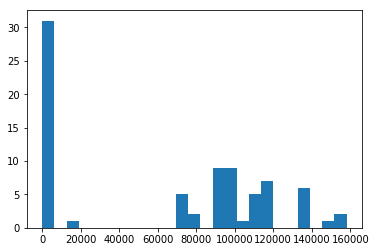

In [23]:
column_names = df_azdias.columns
column_isnull = df_azdias.isnull().sum().tolist()

plt.hist(column_isnull, bins=25);

Okay, we can see that the majority of colums have very low NaN values, we can go ahead and ignore them.

There are a couple more columns that have NaNs at the level between 50,000 and 160,000. We already removed outliers so we shouldn't go removing more.

(I went on and removed more in another session by accident but it gave me no more NaN values to work with for later parts of this notebook, this seems too easy to me and so I decided not to drop these columns even if it would make my life a lot easler 🤔)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Alright, I managed to remove some columns but I was not able to find a major reason for why the data was missing which is why I cant really generalise this to remove more columns. 

The outlier columns that were removed are as follows
* `AGER_TYP`
* `GEBURTSJAHR`
* `TITEL_KZ`
* `ALTER_HH`
* `KK_KUNDENTYP`
* `KBA05_BAUMAX`

I noticed that there are a lot of rows which have a lot of missing data, I got ahead of myself and started removing them before I realised that step 1.1.3 was all about doing just that.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
nan_rows = df_azdias.isnull().sum(axis=1).tolist()

df_azdias.isnull().sum(axis=1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

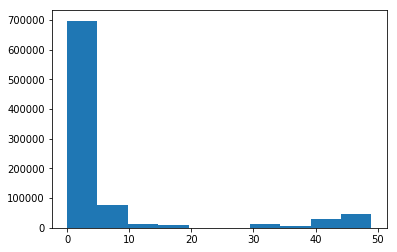

In [25]:
# Plot the distribution of columns above
plt.hist(nan_rows);

Ah, well it seems that it is true that there are two distributions of NaN data. One above 20 and another beneath it.

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

df_azdias_p1 = df_azdias[df_azdias.isnull().sum(axis=1) < 20]

df_azdias_p1.shape

(797077, 79)

In [27]:
df_azdias_p2 = df_azdias[df_azdias.isnull().sum(axis=1) >= 20]

df_azdias_p2.shape

(94144, 79)

In [28]:
# Make sure the data was split correctly in twain
assert df_azdias.shape[0] == df_azdias_p1.shape[0] + df_azdias_p2.shape[0]

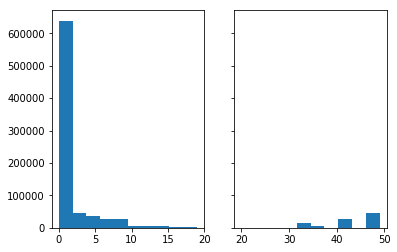

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(df_azdias_p1.isnull().sum(axis=1).tolist())
ax2.hist(df_azdias_p2.isnull().sum(axis=1).tolist());

Since we dropped a lot of columns earlier, I'll just update feat_info so that it contains only features that we still have and rename the dataframe that we'll be using from now on so that it's less verbose.

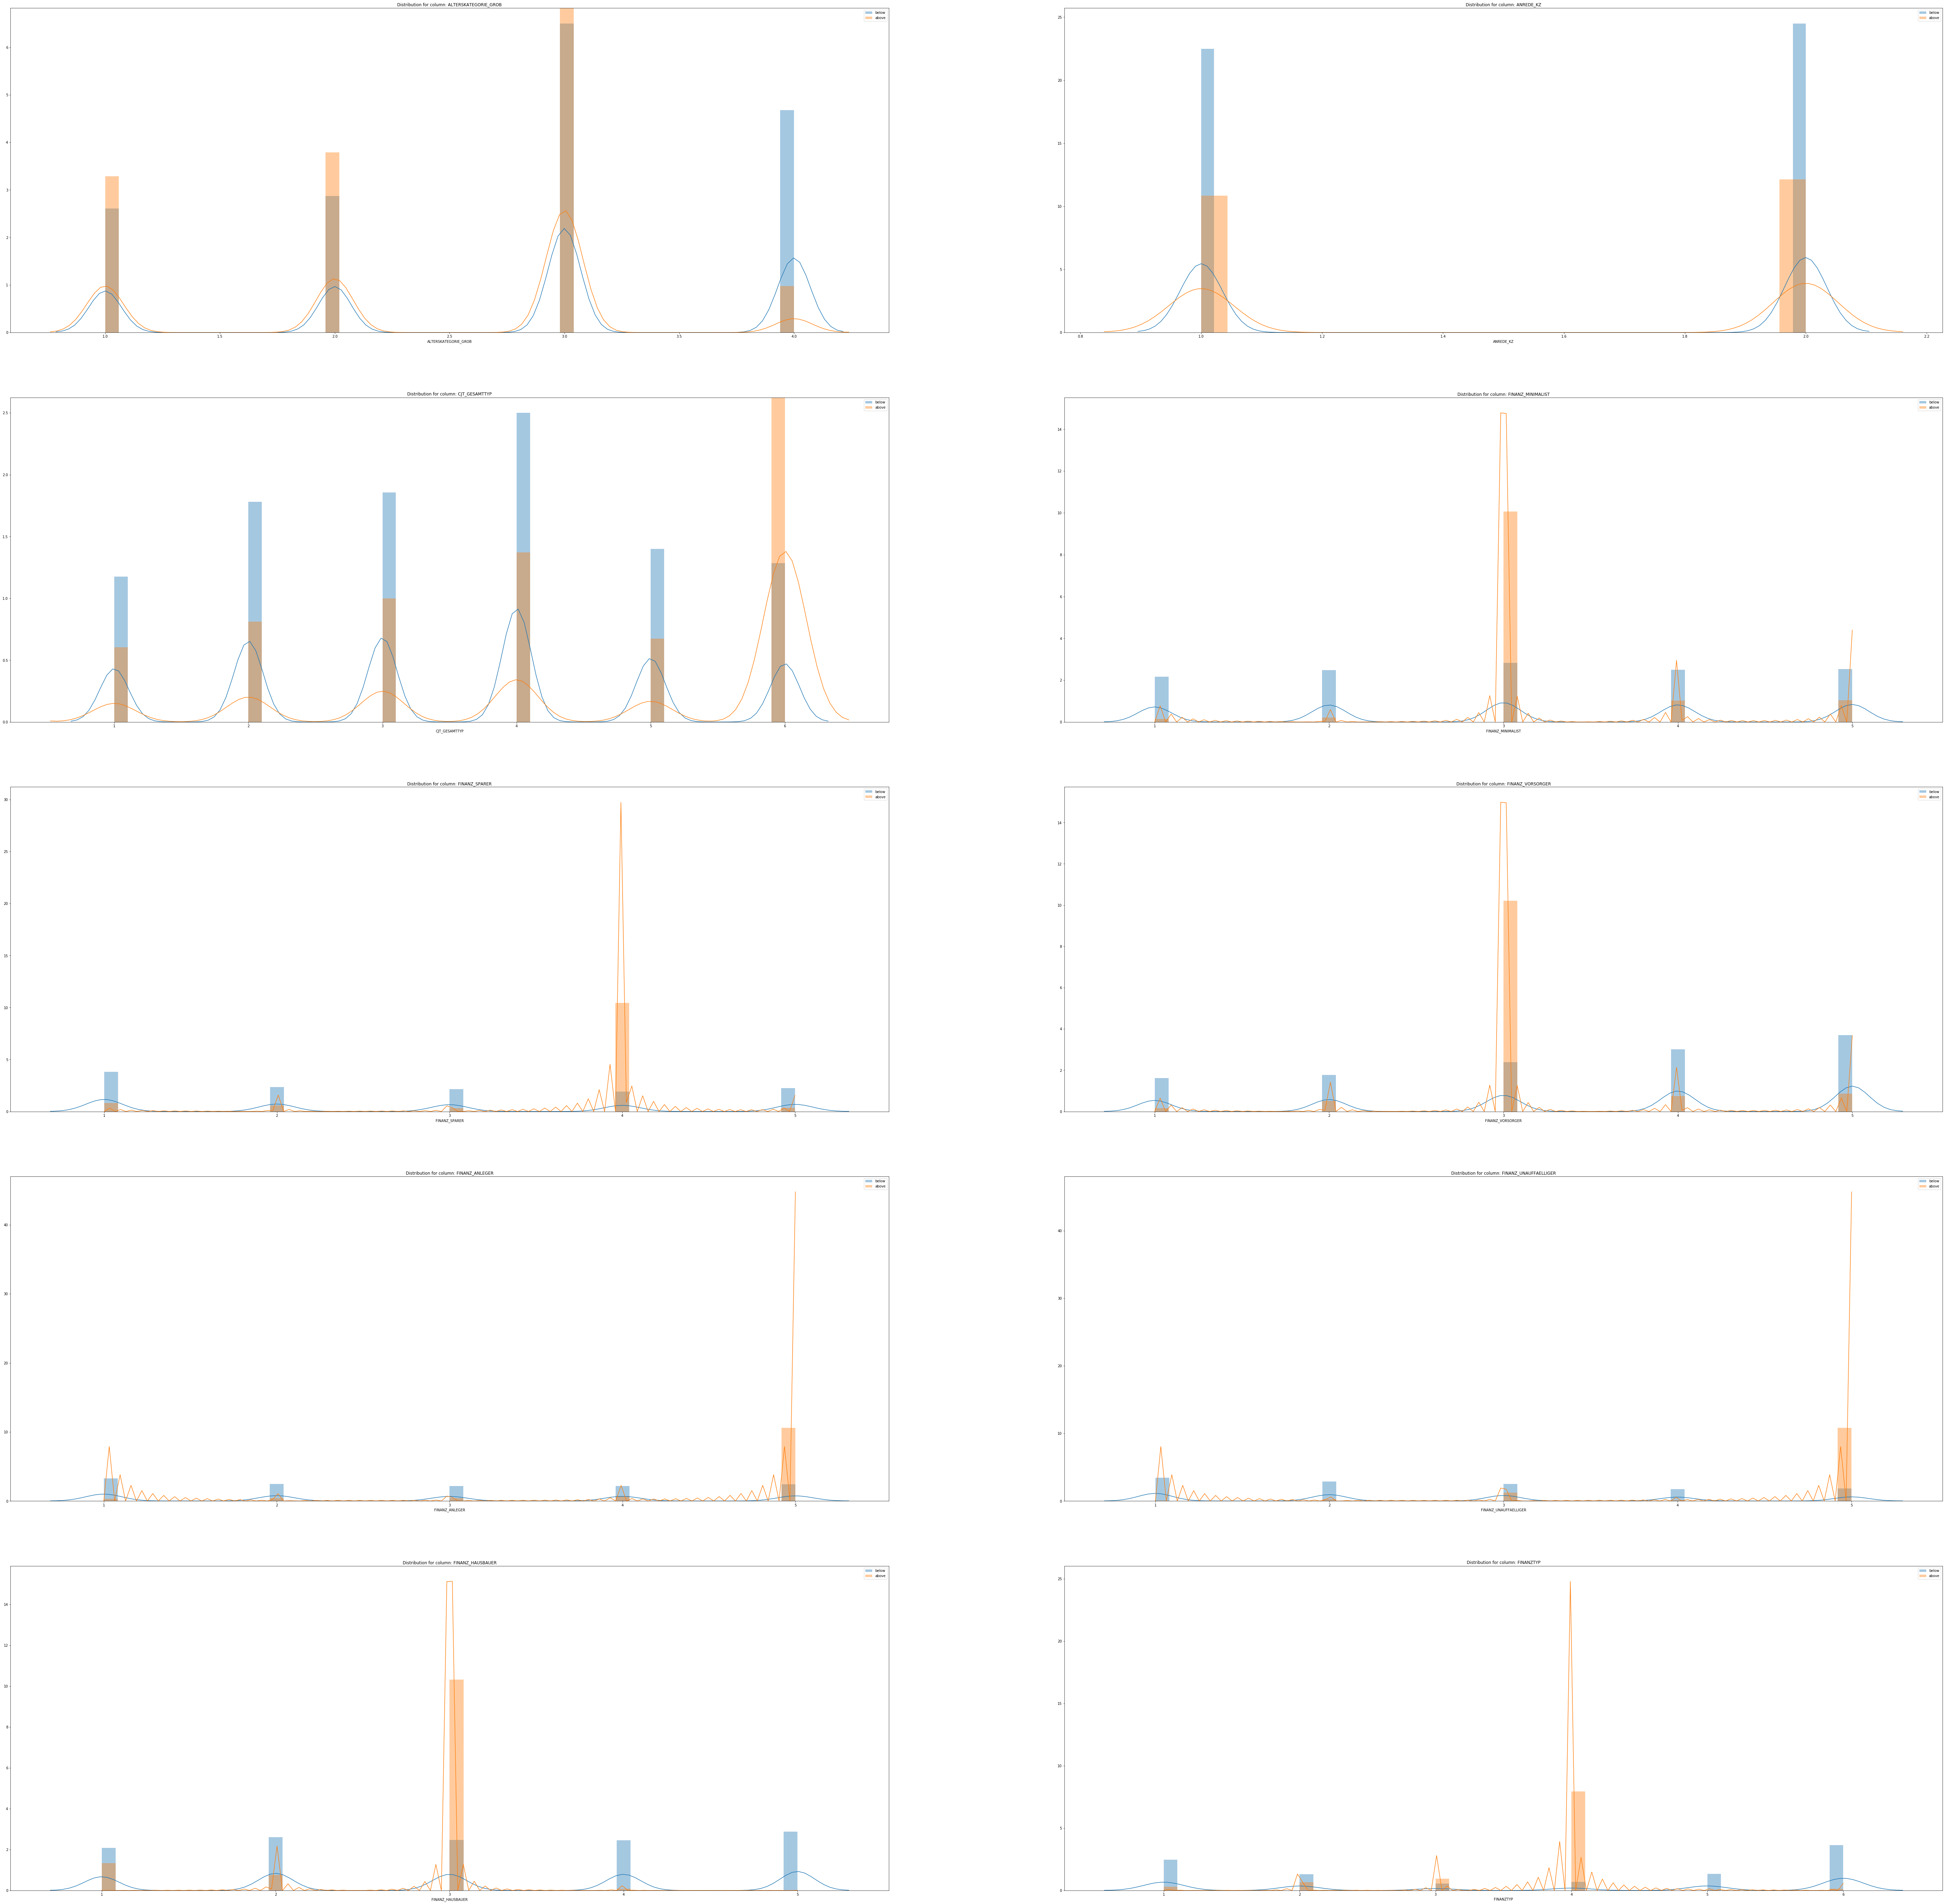

In [30]:
plt.figure(figsize=(100,100))
for i, col in enumerate(df_azdias.columns[:10]):
    plt.subplot(5, 2, i+1)
    sns.distplot(df_azdias_p1[col][df_azdias_p1[col].notnull()], label='below')
    sns.distplot(df_azdias_p2[col][df_azdias_p2[col].notnull()], label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

Here we can see the distributions of `NOT NULL` values within the dataset. Where blue denotes values from the section of the dataset with lower concentration of `NaN`s and with orange denoting the section with higher NaNs. (`below` and `above` denote whether the dataframe is from above/below the cutoff value.)

We can see that the `below` dataset (i.e. `df_azdias_p1`) has higher values across the board and this is why we are using this part of the dataset and discarding the orange part.

In [31]:
df_azdias2 = df_azdias_p1.copy()

df_azdias2_cols = df_azdias2.columns.tolist()

feat_info = feat_info[feat_info['attribute'].isin(df_azdias2_cols)]

#### Discussion 1.1.3: Assess Missing Data in Each Row

We split the dataset in two and made a plot, we did this to make a decision over which rows to drop. As suggested above, we drop rows which have an irredeemable number of null values in the rows. You can't expect to recreate the data for these individuals anyway.

We can see that in p1 of the datset, we have rows that have very low null values, this is an "information rich" dataset which we will use for the rest of the analysis. *p2 will be discarded.*

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many datatypes are there?
feat_info.type.nunique()

4

We can see that there are 4 data types!

In [33]:
# How many features are there of each data type?
feat_info.groupby("type").count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


Here, we can see that most of the data is categorical data. 6 are mixed, 6 are numeric and 49 are ordinal. 

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

___
Since this project is due in a week, my gf is coming to visit mine for a week tomorrow and I have a job. I'd like to keep this as simple as possible. Hence, I am going to be dropping multi-level categoricals even though using a OneHotEncoder is fun and will probably lead to a more robust analysis in the long-run because I'll be losing a lot of information that I'd like to have before applying PCA.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_categorical = feat_info[feat_info["type"] == "categorical"].attribute.tolist()

In [35]:
# If binary are 2 level and multi-level are >=3 then...
categorical_feats = df_azdias_p1[feat_categorical].nunique() <3 # Aw, I made a heart
categorical_binary = categorical_feats[categorical_feats].index.tolist()
categorical_multilevel = categorical_feats[~categorical_feats].index.tolist()

categorical_binary # The cream of the crop

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [36]:
# Print remaining categorical columns
categorical_multilevel # Filth that must be purged w/ fire :) 

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
# lololol, see warning above.
df_azdias2.drop(categorical_multilevel, axis=1, inplace=True)

In [38]:
df_azdias2

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


This dataset is starting to look pretty good, if I do say so myself!

In [39]:
# But alas, I need to make sure that the binary variables that I have left take a good form.
df_azdias2[categorical_binary]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W
6,2,0,0.0,1.0,W
7,1,0,0.0,1.0,W
8,1,1,0.0,2.0,W
9,2,1,0.0,2.0,W
10,2,0,0.0,2.0,W


In [40]:
df_azdias2["SOHO_KZ"] = df_azdias2["SOHO_KZ"].astype(int)
df_azdias2["ANREDE_KZ"] =  df_azdias2["ANREDE_KZ"].map({1: 0, 2: 1})
df_azdias2["VERS_TYP"] =  df_azdias2["VERS_TYP"].map({1: 0, 2: 1})

# This isn't working for some reason but having a float instead of int shouldnt matter
df_azdias2["VERS_TYP"] = df_azdias2[~df_azdias2["VERS_TYP"].isnull()]["VERS_TYP"].astype(int) 

df_azdias2["OST_WEST_KZ"] = df_azdias2["OST_WEST_KZ"].map({"W": 0, "O": 1})

In [41]:
# Check to see if changes work
df_azdias2[categorical_binary]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,1,0,1,1.0,0
2,1,1,0,0.0,0
3,1,0,0,0.0,0
4,0,0,0,1.0,0
5,1,0,0,1.0,0
6,1,0,0,0.0,0
7,0,0,0,0.0,0
8,0,1,0,1.0,0
9,1,1,0,1.0,0
10,1,0,0,1.0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

As I said, I dropped multi-level categorical variables in the interest of time. I changed the binary variables to values between 0 and 1. I debated using 1 and 2 instead, but it shouldn't really matter since the information comes from the values being different instead of 1 being greater than 0. I left the column `VERS_TYP` as a float type because switching to int is not very easy (maybe I could do it using a for-loop) and it should not really matter for the analysis AFAIK. Maybe if we were switching from int to float it would matter since float carries more information than an int due to having decimal places.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [42]:
# For context
mixed_cols = feat_info[feat_info["type"]=="mixed"].attribute.tolist()
df_azdias2[mixed_cols].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
3,NaN,NaN,8.0,7.0,12,1.0
4,32.0,10.0,8.0,3.0,43,2.0
5,8.0,2.0,3.0,7.0,54,1.0


It took me a while to realise how `PRAEGENDE_JUGENDJAHRE` is encoded using the attached markdown file. We need to split things up according to movement and decade, got it!

Movement can be encoded into a simple binary column since it is Mainstream vs Avantgarde. We'll have one continuous variable for the decade. Although it could also be possible to split decades into various dummy variables using oneHotEncoding. I am not sure which is better but I guess I already set a precedent by not using oneHotEncoding for the sake of time.

Now that I think about it, if we had the 2000s 2010s and others then it might not be so easy to do numerical values. It still feels kind of wrong because although this is a time dimension, you don't really think of the 90s as being greater than the 80s unless you have your own biases.

In [43]:
def praegende_jugendjahre_transform(x, feature="movement"):
    """
    Function that splits this features into generation and movement for use with lambda function.
    """
    if type(x) == np.NaN: return x
    if feature == "generation": definitions = {-1: np.NaN, 0: np.NaN,
                                              1: 40, 2: 40,
                                              3: 50, 4: 50,
                                              5: 60, 6: 60, 7: 60,
                                              8: 70, 9: 70,
                                              10:80, 11:80, 12:80, 13:80,
                                              14:90, 15:90}
        
    else: 
        definitions = {-1: np.NaN, 0: np.NaN,
                         1: 1, 2: 0,
                         3: 1, 4: 0,
                         5: 1, 6: 0, 7: 0,
                         8: 1, 9: 0,
                         10:1, 11:0, 12:1, 13:0,
                         14:1, 15:0}
        
    y = definitions[x]
    
    return y

In [44]:
# Trick python because the lambda function doesnt handle nan values that well
df_azdias2["PRAEGENDE_JUGENDJAHRE"].fillna(-1, inplace=True)

# Create new columns
df_azdias2["GENERATION"] = df_azdias2["PRAEGENDE_JUGENDJAHRE"].map(lambda x:
                                                                   praegende_jugendjahre_transform(x,
                                                                                                   "generation"))
df_azdias2["MOVEMENT"] = df_azdias2["PRAEGENDE_JUGENDJAHRE"].map(lambda x:
                                                                   praegende_jugendjahre_transform(x,
                                                                                                   "movement"))
# Drop old columns
df_azdias2.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df_azdias2["CAMEO_INTL_2015"].head(15)

1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
10    51
12    43
13    33
15    41
16    41
18    24
Name: CAMEO_INTL_2015, dtype: object

Once again, having a look at the documentation helps a lot in terms of how we deal with this data. I like the idea of splitting this into two numerical columns. I'll use the map function as before and write a lambda function to turn this integer into a string, which I can then split and turn back into an integer before saving...

Actually! I have an idea, what if we can save two columns at once by writing a function that returns two values? (Note, this returns a tuple, but nice idea.)

In [46]:
def CAMEO_INTL_2015_transform(x, is_wealth):
    """
    Function that splits this features into wealth and life stage for use with lambda function.
    """
    if x == np.NaN: return np.NaN
    
    x = str(x)
    
    if is_wealth == 1: y = x[0]
    if is_wealth == 0: y = x[1]
    
    if y == 'a': y = np.NaN # Very sneaky
    
    return y

In [47]:
df_azdias2["WEALTH"] = df_azdias2["CAMEO_INTL_2015"].map(lambda x: CAMEO_INTL_2015_transform(x, 1))
df_azdias2["LIFE_STAGE"] = df_azdias2["CAMEO_INTL_2015"].map(lambda x: CAMEO_INTL_2015_transform(x, 0))
df_azdias2.drop("CAMEO_INTL_2015", axis=1, inplace=True)

In [48]:
feat_info["attribute"][feat_info["type"]=="mixed"][~feat_info["attribute"].isin(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"])]

15    LP_LEBENSPHASE_FEIN
16    LP_LEBENSPHASE_GROB
56               WOHNLAGE
79            PLZ8_BAUMAX
Name: attribute, dtype: object

We can see from some filtering that we have a couple of other "mixed" attributes remaining. Two of them concerning the stage someone is in their live, one about the neighborhood quality and the last one about the most common building type within the PLZ8 region. 

In [49]:
df_azdias2[["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"]]

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB
1,21.0,6.0
2,3.0,1.0
3,NaN,NaN
4,32.0,10.0
5,8.0,2.0
6,2.0,1.0
7,5.0,2.0
8,10.0,3.0
9,4.0,1.0
10,6.0,2.0


From the documentation, we can see that `LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` encode the same kind of information. Hence, we can likely drop one and keep the other without loosing too much information. We'll drop the column with more information since the bigger picture will be easier to encode.

Since we already have columns encoding wealth, we could drop this aspect of the feature. However, I think that this might help differentiate between different levels of wealth, so I'll try and keep this column.

In [50]:
df_azdias2.drop("LP_LEBENSPHASE_FEIN", axis=1, inplace=True)

In [51]:
def LP_LEBENSPHASE_GROB_transform(x, is_married):
    """
    Function that splits this features into binary columns of singles/families and low/high income households
    """
    
    if is_married == "MARRIAGE_STATUS": definitions = {-1: np.NaN, 0: np.NaN,
                                              1: 0, 
                                              2: 0,
                                              3: 0, 
                                              4: 0,
                                              5: 0, 
                                              6: 0, 
                                              7: 0,
                                              8: 1, 
                                              9: 1,
                                              10:1, 
                                              11:1, 
                                              12:1}
        
    else: 
        definitions = {-1: np.NaN, 0: np.NaN,
                      1: 0, 
                      2: 0,
                      3: 1, 
                      4: 0,
                      5: 1, 
                      6: 0, 
                      7: 0,
                      8: 1, 
                      9: 0,
                      10:0, 
                      11:1, 
                      12:1}
        
    y = definitions[x]
    
    return y

It should be noted that whether some of these variables were ambiguous and so I used my best judgment here. If it was unclear if a catergory was wealthy I assumed that it wasn't. Hence, there might be some bias in the results here.

In [52]:
df_azdias2["LP_LEBENSPHASE_GROB"].fillna(-1, inplace=True)
df_azdias2["WEALTH"] = df_azdias2["LP_LEBENSPHASE_GROB"].map(lambda x: LP_LEBENSPHASE_GROB_transform(x, 0))
df_azdias2["MARRIAGE_STATUS"] = df_azdias2["LP_LEBENSPHASE_GROB"].map(lambda x: LP_LEBENSPHASE_GROB_transform(x, "MARRIAGE_STATUS"))
df_azdias2.drop("LP_LEBENSPHASE_GROB", axis=1, inplace=True)

For `WOHNLAGE`, I will make the assumption that neighborhoods are also simply good or bad for the sake of time. I'm not entirely sure what to make of `PLZ8_BAUMAX`, so I will also drop it in the interest of time.

In [53]:
df_azdias2["WOHNLAGE"].unique()

array([ 4.,  2.,  7.,  3.,  5.,  1.,  8.,  0.])

In [54]:
def WOHNLAGE_transform(x):
    """
    Function that splits this features into binary columns of singles/families and low/high income households
    """
    
    definitions = {-1: np.NaN,
                  0: np.NaN,
                  1: 1,
                  2: 1,
                  3: 1,
                  4: 0,
                  5: 0, # lol, this one doesn't have a 6 value
                  7: np.NaN,
                  8: np.NaN, # These aren't connected to neighborhood quality so I'm removing them.
                  }
        
    y = definitions[x]
    
    return y

In [55]:
df_azdias2["WOHNLAGE"].fillna(-1, inplace=True)
df_azdias2["WOHNLAGE"] = df_azdias2["WOHNLAGE"].map(lambda x: WOHNLAGE_transform(x))
df_azdias2.drop(["WOHNLAGE","PLZ8_BAUMAX"], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Alright, this took quite some time but I managed to re-encode the "mixed" features of the dataset meaning that it should be more or less complete for use now. 

I re-encoded most of the columns except for PLZ8_BAUMAX. It was also possible to drop the wealth dimension but I decided to keep it for a little bit of extra interesting information.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

---
*Note: I drop columns as I go along witht the data, cleaning above so these cells will be left blank.* The only thing to do will be do deal with missing data but, as mentioned, this will be dealt with in step 2.1.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [57]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [58]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    Just don't look at how the cleaning is done, its so dirty it could fit into an XXX novel.

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    def praegende_jugendjahre_transform(x, feature="movement"):
        """
        Function that splits this features into generation and movement for use with lambda function.
        """
        if type(x) == np.NaN: return x
        if feature == "generation": definitions = {-1: np.NaN, 0: np.NaN,
                                                  1: 40, 2: 40,
                                                  3: 50, 4: 50,
                                                  5: 60, 6: 60, 7: 60,
                                                  8: 70, 9: 70,
                                                  10:80, 11:80, 12:80, 13:80,
                                                  14:90, 15:90}

        else: 
            definitions = {-1: np.NaN, 0: np.NaN,
                             1: 1, 2: 0,
                             3: 1, 4: 0,
                             5: 1, 6: 0, 7: 0,
                             8: 1, 9: 0,
                             10:1, 11:0, 12:1, 13:0,
                             14:1, 15:0}

        y = definitions[x]

        return y
    
    
    def CAMEO_INTL_2015_transform(x, is_wealth):
        """
        Function that splits this features into wealth and life stage for use with lambda function.
        """
        if x == np.NaN: return np.NaN

        x = str(x)

        if is_wealth == 1: y = x[0]
        if is_wealth == 0: y = x[1]

        if y == 'a': y = np.NaN # Very sneaky
            
        return y
    
    
    def LP_LEBENSPHASE_GROB_transform(x, is_married):
        """
        Function that splits this features into binary columns of singles/families and low/high income households
        """

        if is_married == "MARRIAGE_STATUS": definitions = {-1: np.NaN, 0: np.NaN,
                                                  1: 0, 
                                                  2: 0,
                                                  3: 0, 
                                                  4: 0,
                                                  5: 0, 
                                                  6: 0, 
                                                  7: 0,
                                                  8: 1, 
                                                  9: 1,
                                                  10:1, 
                                                  11:1, 
                                                  12:1}

        else: 
            definitions = {-1: np.NaN, 0: np.NaN,
                          1: 0, 
                          2: 0,
                          3: 1, 
                          4: 0,
                          5: 1, 
                          6: 0, 
                          7: 0,
                          8: 1, 
                          9: 0,
                          10:0, 
                          11:1, 
                          12:1}

        y = definitions[x]

        return y
    
    
    def WOHNLAGE_transform(x):
        """
        Function that splits this features into binary columns of singles/families and low/high income households
        """

        definitions = {-1: np.NaN,
                      0: np.NaN,
                      1: 1,
                      2: 1,
                      3: 1,
                      4: 0,
                      5: 0, # lol, this one doesn't have a 6 value
                      7: 1,
                      8: 1,
                      }

        y = definitions[x]

        return y
    
    
    # Import a clean version of feat_info
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
    
    for index, row in feat_info.iterrows():
        missing = row["missing_or_unknown"]
        if 'XX' in missing:
            missing = missing.replace("XX", "'XX'")
        if ',X' in missing: 
            missing = missing.replace("X", "'X'")

        missing = ast.literal_eval(missing)
        column = row["attribute"]

        for i in missing:
            df[column].replace(i, np.NaN, inplace=True)
        
    # Drop columns w/ lots of missing values
    # Note: Columns to drop here has been hard-coded so that the same columns as the original dataset is returned
    #       in the case that the top null values are different.
    cols_to_drop = ['GEBURTSJAHR', 'ALTER_HH', 'KBA05_BAUMAX']
    ## ['AGER_TYP' 'TITEL_KZ' 'KK_KUNDENTYP'] Aren't int he dataset to start with

    df.drop(cols_to_drop, axis=1, inplace=True)

    # Split data
    df = df[df.isnull().sum(axis=1) < 20]
    
    # Identify and drop multi-level categorical columns
    feat_categorical = feat_info[feat_info["type"] == "categorical"].attribute.tolist()
    categorical_feats = df[feat_categorical].nunique() <3
    categorical_multilevel = categorical_feats[~categorical_feats].index.tolist()
    df.drop(categorical_multilevel, axis=1, inplace=True)
    
    # Encode binary variables properly
    df["SOHO_KZ"] = df["SOHO_KZ"].astype(int)
    df["ANREDE_KZ"] =  df["ANREDE_KZ"].map({1: 0, 2: 1})
    df["VERS_TYP"] =  df["VERS_TYP"].map({1: 0, 2: 1})
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].map({"W": 0, "O": 1})
    
    
    # Re-Encode `PRAEGENDE_JUGENDJAHRE`
    df["PRAEGENDE_JUGENDJAHRE"].fillna(-1, inplace=True)
    df["GENERATION"] = df["PRAEGENDE_JUGENDJAHRE"].map(lambda x:
                                                                       praegende_jugendjahre_transform(x,
                                                                                                       "generation"))
    df["MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].map(lambda x:
                                                                       praegende_jugendjahre_transform(x,
                                                                                                       "movement"))
    
    # Re-Encode `CAMEO_INTL_2015`
    df["WEALTH"] = df["CAMEO_INTL_2015"].map(lambda x: CAMEO_INTL_2015_transform(x, 1))
    df["LIFE_STAGE"] = df["CAMEO_INTL_2015"].map(lambda x: CAMEO_INTL_2015_transform(x, 0))
    
    
    # Re-Encode `LP_LEBENSPHASE_GROB`
    df["LP_LEBENSPHASE_GROB"].fillna(-1, inplace=True)
    df["WEALTH"] = df["LP_LEBENSPHASE_GROB"].map(lambda x: LP_LEBENSPHASE_GROB_transform(x, 0))
    df["MARRIAGE_STATUS"] = df["LP_LEBENSPHASE_GROB"].map(lambda x: LP_LEBENSPHASE_GROB_transform(x, "MARRIAGE_STATUS"))
    
    # Re-Encode 
    df["WOHNLAGE"].fillna(-1, inplace=True)
    df["WOHNLAGE"] = df["WOHNLAGE"].map(lambda x: WOHNLAGE_transform(x))
    
    # Drop straggling features
    df.drop(["WOHNLAGE","PLZ8_BAUMAX", 
                     "LP_LEBENSPHASE_GROB",
                     "LP_LEBENSPHASE_FEIN",
                     "PRAEGENDE_JUGENDJAHRE",
                     "CAMEO_INTL_2015"], axis=1, inplace=True)
    
    # Drop remaining null value rows
    df.dropna(axis=0, inplace=True)

    return df

Man, this thing above should be its own package!

Yes, I had to test if functions work within functions explicitly for this :P 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_azdias2.dropna(axis=0, inplace=True)

In [60]:
# Apply feature scaling to the general population demographics data.
feature_scaler = StandardScaler().fit(df_azdias2)
azdias2_scaled = feature_scaler.transform(df_azdias2)

### Discussion 2.1: Apply Feature Scaling

There was an issue where, for some reason, there were a bunch of 'a' strings in the `LIFE_STAGE` feature that I generated from the `CAMEO_INTL_2015` feature.

I just made it so that it was encoded to `np.NaN` which ensures that it gets dropped later.,

I really hope I am done with the data issues now. As much as it is fun to clean data, it's not so fun when under time-pressure.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.
pca_model = PCA(n_components=int(azdias2_scaled.shape[1]/2)) # Calculated number of coponents that is at least half the number of features
pca_out = pca_model.fit_transform(azdias2_scaled)

In [62]:
pca_model.explained_variance_ratio_

array([ 0.17311438,  0.13466717,  0.09504981,  0.05343925,  0.03837538,
        0.03155695,  0.03043322,  0.02658656,  0.02356729,  0.02163779,
        0.0205161 ,  0.01881505,  0.01861988,  0.01608071,  0.01590216,
        0.01538141,  0.01480998,  0.01421472,  0.01319373,  0.0124895 ,
        0.01232729,  0.01167133,  0.01119119,  0.01082142,  0.0104239 ,
        0.00915232,  0.00805078,  0.00766117,  0.00753394,  0.00719604,
        0.00715623,  0.00645925])

In [63]:
# Investigate the variance accounted for by each principal component.
n_components=len(pca_model.explained_variance_ratio_)
ind = np.arange(n_components)
vals = pca_model.explained_variance_ratio_

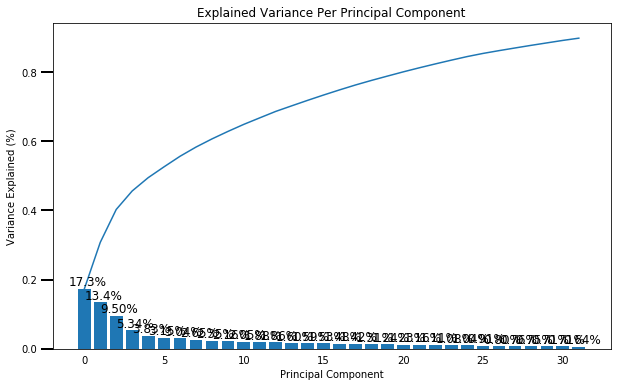

In [64]:
# Code below code was taken from the helper_function.py file in the udacity-student-workspace!
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(n_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component');

In [65]:
# Re-apply PCA to the data while selecting for number of components to retain. (Retaining 2 dimensions)
pca_model = PCA(n_components=3) # Calculated number of coponents that is at least half the number of features
pca_out = pca_model.fit_transform(azdias2_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

We can see that most of the variability is captured within the first component as expected. However, it is not very overwhelming at just under 20%. If we take the first 3 components then we end up with 

We can see that most of the variability within the data can be seen within the first principle component, meaning that we can probably make a 1d plot and make some kind of prediction based on that. (If there are clusters in 1d then we can make a logistic regression or something to make predictions in the future, but that's outside the scope of this project.)

There is a little bit of variability captured in the 3rd PC, but this might make plotting the data a little more difficult for visualisation.

I wanted to choose to keep 2 principle components, but since the ruberic says `weights on at least three principal components are used `, I chose to keep 3 instead.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [66]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_PC_to_features(model, pca_number):
    """
    Maps n Principle Components to features in original dataset
    
    INPUT: PCA Model fitted and tranformed to data and the principle component to be analysed. (1 by default)
    OUTPUT: Dataframe mapping variance of 1st pca to original features
    """
    
    pca_number = pca_number-1
    
    mapping = model.components_[pca_number] # I'm assuming it's in order of 
    original_columns = df_azdias2.columns.tolist()
    
    dict_to_frame = {"col": original_columns,
                    "PC_weight": mapping}

    df = pd.DataFrame(dict_to_frame, columns=["col", "PC_weight"]).sort_values(by="PC_weight",
                                                                               axis=0,
                                                                               ascending=False)
    
    return df

In [67]:
pc_map1 = map_PC_to_features(pca_model, 1).head()
pc_map1["n_component"] = "1"

map_PC_to_features(pca_model, 1).head()

,col,PC_weight
53,PLZ8_ANTG3,0.208761
54,PLZ8_ANTG4,0.202734
29,HH_EINKOMMEN_SCORE,0.194458
58,ORTSGR_KLS9,0.180542
43,EWDICHTE,0.177795


In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_map2 = map_PC_to_features(pca_model, 2).head()
pc_map2["n_component"] = "2"

map_PC_to_features(pca_model, 2).head()

,col,PC_weight
0,ALTERSKATEGORIE_GROB,0.242362
17,SEMIO_ERL,0.224009
4,FINANZ_VORSORGER,0.211514
16,SEMIO_LUST,0.166995
10,RETOURTYP_BK_S,0.159990


In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc_map3 = map_PC_to_features(pca_model, 3).head()
pc_map3["n_component"] = "3"

map_PC_to_features(pca_model, 3).head()

,col,PC_weight
15,SEMIO_VERT,0.345762
11,SEMIO_SOZ,0.263547
12,SEMIO_FAM,0.251530
18,SEMIO_KULT,0.231156
2,FINANZ_MINIMALIST,0.152426


In [70]:
pc_map = pd.concat([pc_map1, pc_map2, pc_map3])

In [71]:
pc_map[pc_map["PC_weight"] > 0.03]

,col,PC_weight,n_component
53,PLZ8_ANTG3,0.208761,1
54,PLZ8_ANTG4,0.202734,1
29,HH_EINKOMMEN_SCORE,0.194458,1
58,ORTSGR_KLS9,0.180542,1
43,EWDICHTE,0.177795,1
0,ALTERSKATEGORIE_GROB,0.242362,2
17,SEMIO_ERL,0.224009,2
4,FINANZ_VORSORGER,0.211514,2
16,SEMIO_LUST,0.166995,2
10,RETOURTYP_BK_S,0.159990,2


In [72]:
pc_important_cols = pc_map[pc_map["PC_weight"] > 0.03]["col"]

In [73]:
len(pc_map[pc_map["PC_weight"] > 0.03])

15

### Discussion 2.3: Interpret Principal Components

We can see that there are 15 columns that contribute to the main variance of the dataset. None of these are the variables that I engineered so that was all just a waste of time and I was right to not be shy about dropping columns! :D (Except maybe for Generation, which is a very important column for the PCA.)

Here is an explanation for the most important variables in the dataset:
* `PLZ8_ANTG3`: Number of 6-10 family houses in the PLZ8 region
* `PLZ8_ANTG4`: Number of 10+ family houses in the PLZ8 region
* `HH_EINKOMMEN_SCORE`: Estimated household net income
* `ORTSGR_KLS9`: Size of community
* `EWDICHTE`: Density of households per square kilometer
* `ALTERSKATEGORIE_GROB`: Estimated age based on given name analysis
* `SEMIO_ERL`, `SEMIO_VERT`, `SEMIO_SOZ`, `SEMIO_FAM`, `SEMIO_KULT`: Personality typology, for each dimension:.
* `FINANZ_VORSORGER`, `FINANZ_MINIMALIST`:Financial typology
* `RETOURTYP_BK_S`: Return type (How likely they are return to shopping)

We can see that the PCA is trying to find correlations in the data according to population density, and the capability of people within that area to be large spenders in addition to age and personality types.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [74]:
KM_score_dict = {"n_clusters": [],
                "score": []}
# Over a number of different cluster counts...

for i in range(1, 12):
    print("Running KMeans for {} cluster(s)".format(i))
    
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i, random_state=69) # Hooray for reproducible science
    KM_model = kmeans.fit(pca_out)
    KM_labels = KM_model.predict(pca_out)
    
    # compute the average within-cluster distances.
    KM_score = np.abs(KM_model.score(pca_out))
    
    # Save the score for later comparison
    KM_score_dict["n_clusters"].append(i)
    KM_score_dict["score"].append(KM_score)
    
df_KM_score = pd.DataFrame(KM_score_dict, columns=["n_clusters", "score"])

df_KM_score

Running KMeans for 1 cluster(s)
Running KMeans for 2 cluster(s)
Running KMeans for 3 cluster(s)
Running KMeans for 4 cluster(s)
Running KMeans for 5 cluster(s)
Running KMeans for 6 cluster(s)
Running KMeans for 7 cluster(s)
Running KMeans for 8 cluster(s)
Running KMeans for 9 cluster(s)
Running KMeans for 10 cluster(s)
Running KMeans for 11 cluster(s)


,n_clusters,score
0,1,1.631815e+07
1,2,1.113981e+07
2,3,8.297617e+06
3,4,6.713149e+06
4,5,5.558551e+06
5,6,4.623294e+06
6,7,3.753414e+06
7,8,3.103784e+06
8,9,2.854085e+06
9,10,2.606699e+06


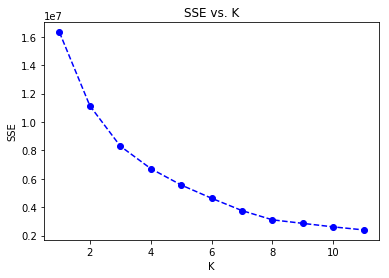

In [75]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Once again, code taken from helper functions in the udacity workspace!

plt.plot(df_KM_score["n_clusters"], df_KM_score["score"], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

We can se that most of the score has been gotten at around 8-10 clusters and there isn't much gain to the score afterward. Hence, I'll say that there are 8 clusters in the data.

In [76]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=8, random_state=69)
KM_model = kmeans.fit(pca_out)
KM_labels = KM_model.predict(pca_out)

### Discussion 3.1: Apply Clustering to General Population

We discovered in this section that we are finding correlations between people who spend a lot of money, their personality type and how concentrated the population density is. I think this is really interesting because it shows that there is a strong social and age aspect to spending.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [77]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [78]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers);

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykern

In [79]:
# Scale data
customers_scaled = feature_scaler.transform(customers)

In [80]:
# Use PCA on Data
pca_customers_out = pca_model.transform(customers_scaled)

In [81]:
# Cluster Data
KM_customers_labels = KM_model.predict(pca_customers_out)

I didn't realise I was doing a train/test thing here and so I made a mistake refitting the data to my testing set. I've tried to not do that here.

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [82]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

custLabels_unique, custLabels_counts = np.unique(KM_customers_labels, return_counts=True)
custLabels_dict = {"cluster_label": custLabels_unique,
                      "customer_label_counts": custLabels_counts}

df_custLabels = pd.DataFrame(custLabels_dict)

df_custLabels

,cluster_label,customer_label_counts
0,0,59971
1,1,1967
2,2,14352
3,3,22555
4,4,1085
5,5,11849
6,6,2822
7,7,1042


In [83]:
popLabels_unique, popLabels_counts = np.unique(KM_labels, return_counts=True)
popLabels_dict = {"cluster_label": popLabels_unique,
                      "population_label_counts": popLabels_counts}

df_popLabels = pd.DataFrame(popLabels_dict)

df_popLabels

,cluster_label,population_label_counts
0,0,106151
1,1,64669
2,2,87988
3,3,100887
4,4,57027
5,5,88665
6,6,52329
7,7,65494


In [84]:
df_labelsCounts = df_custLabels.join(df_popLabels, on="cluster_label", how="inner", lsuffix="_", rsuffix="")[["cluster_label", "customer_label_counts", "population_label_counts"]]

df_labelsCounts


,cluster_label,customer_label_counts,population_label_counts
0,0,59971,106151
1,1,1967,64669
2,2,14352,87988
3,3,22555,100887
4,4,1085,57027
5,5,11849,88665
6,6,2822,52329
7,7,1042,65494


In order to compare the values, I need to make the numbers a percentage of the total.

In [85]:
df_labelsCounts["customer_label_counts"] = df_labelsCounts["customer_label_counts"]/df_labelsCounts["customer_label_counts"].sum()
df_labelsCounts["population_label_counts"] = df_labelsCounts["population_label_counts"]/df_labelsCounts["population_label_counts"].sum()
df_labelsCounts["difference"] = df_labelsCounts["customer_label_counts"] - df_labelsCounts["population_label_counts"]
df_labelsCounts

,cluster_label,customer_label_counts,population_label_counts,difference
0,0,0.518587,0.170329,0.348258
1,1,0.017009,0.103768,-0.086758
2,2,0.124106,0.141185,-0.017079
3,3,0.195040,0.161883,0.033157
4,4,0.009382,0.091505,-0.082123
5,5,0.102462,0.142271,-0.039810
6,6,0.024403,0.083967,-0.059564
7,7,0.009010,0.105091,-0.096081


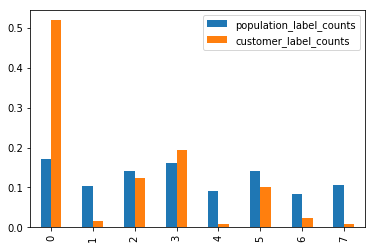

In [86]:
df_labelsCounts[["population_label_counts", "customer_label_counts"]].plot(kind="bar");

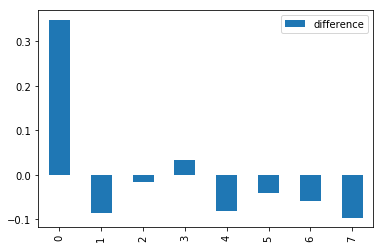

In [87]:
df_labelsCounts[["difference"]].plot(kind="bar");

I've been having troubles where I've had to re-write this analysis to make changes but now that I've set a seed, hopefully my results from this analysis are more stable! Once gain, hooray for reproducible science

We can see that cluster 0 is massively over-represented. Cluster 3 is slightly overrepresented.

Clusters 1, 4 and 7 are under, represented.

Hence, if we are to do targeting then we should target clusters 0 and 3 and try to avoid 1, 4 and 7 as much as possible.

In [88]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customers["labels"] = KM_customers_labels

In [89]:
overrep_cust = customers[(customers["labels"] == 0) | (customers["labels"] == 3)][pc_important_cols].mode().iloc[0].tolist()

In [90]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [91]:
underrep_cust = customers[(customers["labels"] == 1) | 
                          (customers["labels"] == 4) |
                          (customers["labels"] == 7)][pc_important_cols].mode().iloc[0].tolist()

In [92]:
# Compare the two

df_compare_cust = pd.DataFrame({"col": pc_important_cols,
                               "under_represented": underrep_cust,
                               "over_represented": overrep_cust})

df_compare_cust

,col,over_represented,under_represented
53,PLZ8_ANTG3,1.0,2.0
54,PLZ8_ANTG4,0.0,1.0
29,HH_EINKOMMEN_SCORE,1.0,5.0
58,ORTSGR_KLS9,5.0,9.0
43,EWDICHTE,2.0,6.0
0,ALTERSKATEGORIE_GROB,4.0,2.0
17,SEMIO_ERL,7.0,5.0
4,FINANZ_VORSORGER,5.0,2.0
16,SEMIO_LUST,7.0,2.0
10,RETOURTYP_BK_S,5.0,2.0


* PLZ8_ANTG3: Over, lower share of 6-10 homes. Under, average share
* PLZ8_ANTG4: Over, no 10+ family homes. Under, Lower share of 10+ family homes
* HH_EINKOMMEN_SCORE: Over, high income. Under, average income
* ORTSGR_KLS9: Same size communities
* EWDICHTE: Over, smaller housholds. Under, very concentrated households
* ALTERSKATEGORIE_GROB:  Over, >60 years old. Under, 46-60 years old.
* SEMIO_ERL: ... (Skipping personality traits because I am not sure what these columns mean.)
* FINANZ_VORSORGER: Over, Very low. Under, low.
* SEMIO_LUST: ...
* RETOURTYP_BK_S: Over, minimal returner. Under, normal returner
* SEMIO_VERT: ... 
* SEMIO_SOZ: ...
* SEMIO_FAM: ...
* SEMIO_KULT: ...
* FINANZ_MINIMALIST: Financial typology, ...
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

We can see that we're looking for people who are living in rural areas and who are older. Unfortunately, older people tend to be difficult returning customers and are not always easy to pursuade.

However, our under-represented population also seems to be financially conservative just a little bit poorer and live in more built up areas. This might be used as a case for expansion. (It's important to remember that correlation doesn't equal causation. Our under-represented population might just not be targeted very well.)

However, if we want to continue to target our main segment, then we should try and go after affluent and older individuals. 

It is worth noting that in step 1.1.3 lots of data points were separated out for being too sparse. However, this can also be certain segment of people who are difficult to track or who might otherwise be good customers but have missing values for whatever reason. This adds some bias into the results.

Above it is stated "if you found that this group if qualitatively different from the main bulk of the data, you should treat this as an additional cluster in the analysis".

This data was removed because it is mostly null and I'm somehow meant to compare this to the 8 (or so) clusters that the PCA found. Hence, I can't really know to which cluster it is closest to, even if I did some calculations it would be sketchy at best. I'm just going to outline that it's worth considering like i did above.